In [3]:
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd
from genplasmid.dataset import genbank_to_glm2, read_genbank
import warnings
from datasets import load_dataset

from Bio import BiopythonParserWarning

# Suppress the specific warning
warnings.filterwarnings("ignore", category=BiopythonParserWarning, message="Attempting to parse malformed locus line:")

In [4]:
import torch
import transformers
from transformers import PreTrainedTokenizerFast, GenerationConfig, AutoModel
from huggingface_hub import hf_hub_download
import numpy as np
import os

from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from io import StringIO
from Bio.Seq import Seq
from Bio.SeqFeature import CompoundLocation
import warnings
from Bio import BiopythonParserWarning

from huggingface_hub import hf_hub_download, snapshot_download
PATH = snapshot_download("lingxusb/PlasmidGPT", cache_dir="./genplasmid/plasmidgpt/prediction_models")  

def get_device(): 
    if torch.cuda.is_available():
        device = 'cuda'
    # elif torch.backends.mps.is_available():
    #     device = 'mps'
    else: 
        device = 'cpu'
    return torch.device(device)

DEVICE = get_device()

def load_model() -> torch.nn.Module: 
    path = os.path.join(PATH, "pretrained_model.pt")
    model = torch.load(path, map_location=DEVICE)
    return model

def get_tokenizer(): 
    path = os.path.join(PATH, "addgene_trained_dna_tokenizer.json")
    tokenizer = PreTrainedTokenizerFast(tokenizer_file=path)
    special_tokens_dict = {'additional_special_tokens': ['[PROMPT]', '[PROMPT2]']}
    tokenizer.add_special_tokens(special_tokens_dict)
    tokenizer.pad_token = '[PAD]'
    tokenizer.pad_token_id = tokenizer.vocab['[PAD]']
    return tokenizer
    
def embed(sequence: str, model, tokenizer, average_hidden_states=True) -> torch.Tensor:
    input_ids = tokenizer.encode(sequence, return_tensors='pt').to(DEVICE)
    
    # provied in the plasmidgpt example notebook
    # note that [SEP] = 2 and [PAD] = 3
    special_tokens = torch.tensor([3] * 10 + [2], dtype=torch.long, device=DEVICE)
    input_ids = torch.cat((special_tokens.unsqueeze(0), input_ids), dim=1)

    batch = {'input_ids': input_ids, 'attention_mask': None}

    return embed_batch(batch, model, tokenizer, average_hidden_states)

def embed_batch(batch, model, tokenizer, average_hidden_states=True) -> torch.Tensor:
    model.config.output_hidden_states = True
    with torch.no_grad():

        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        hidden_states = outputs.hidden_states[-1].cpu()

        if average_hidden_states:
            hidden_states = torch.mean(hidden_states, axis=1)
        
        return hidden_states

def embed_dataloader(dataloader, model, tokenizer, average_hidden_states=True):
    embeddings = []
    for batch in tqdm(dataloader):
        batch_embeddings = embed_batch(batch, model, tokenizer, average_hidden_states=average_hidden_states)
        embeddings.extend(batch_embeddings.numpy())
    
    return np.array(embeddings)
    

def genbank_to_plasmidgpt(record: str) -> str:
    if record == '':
        return None
    
    genbank_record = SeqIO.read(StringIO(record), "genbank")
    sequence = str(genbank_record.seq).upper()
    return sequence


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
# open the ../data/plasmidgpt_embeddings.parquet
import pandas as pd
import numpy as np

nuc_seq = pd.read_parquet('../data/nucleotide_sequence.parquet')
nuc_seq.head(10)

,ID,nucleotide_sequence
0,40378,GGAACGGCTCCGCCCACTATTAATGAAATTAAAAATTCCAATTTTA...
1,31426,CCCACCAAACCCAAAAAAAGAGATCTCTATGGCTTACCCATACGAT...
2,10966,GTGATGATGACCGGTACGCGTAGAATCGAGACCGAGGAGAGGGTTA...
3,45491,GCGCCGGTGATGCCGGCCACGATGCGTCCGGCGTAGAGGATCGAGA...
4,138521,CTTATTATCAACCGGGGTACATATGATTGACATGCTAGTTTTACGG...
5,171004,TCTTGAAGTTCACCTTGATGCCGTTCTTCTGCTTGTCGGCCATGAT...
6,201764,TGGCCTATGCGGCCGCGGATCTGCCGGTCTCCCTATAGTGAGTCGT...
7,171349,GTGGCTCTTCAGTGGACGAAAGGGCCTCGTGATACGCCTATTTTTA...
8,172489,GGGGTTTTTTGCTGAAAGGAGGAACTATATCCGGATTGGCGAATGG...
9,21969,GACTTCAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGC...


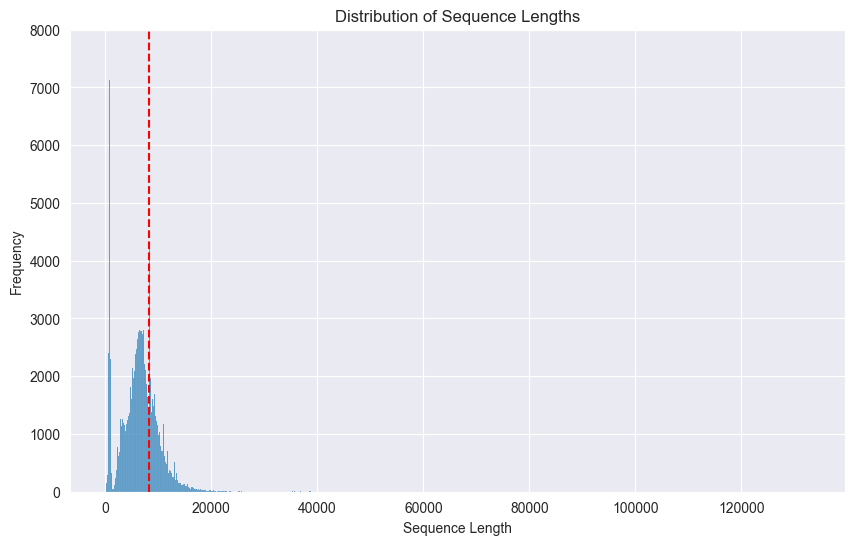

In [6]:
nuc_seq['sequence_length'] = nuc_seq['nucleotide_sequence'].apply(len)

# Plot the distribution of sequence lengths
plt.figure(figsize=(10, 6))
sns.histplot(nuc_seq['sequence_length'], bins=1000)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(x=8192, color='red', linestyle='--')
plt.ylim(0, 8000)
plt.show()

## One-hot encoding

In [7]:
import pickle as pkl
with open('../data/onehot_embedding_dataframe.pkl', 'rb') as f:
    one_hot = pkl.load(f)
one_hot.head(10)

,embedding
ID,
40378,"[[0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1,..."
31426,"[[0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [1,..."
10966,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1,..."
45491,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0,..."
138521,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,..."
171004,"[[0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0,..."
201764,"[[0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0], [0,..."
171349,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0,..."
172489,"[[0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0,..."


In [8]:
import pandas as pd
import numpy as np

def explode_and_pad(df, column_name, target_width=4096, pad_value=[0, 0, 0, 0]):
    # Initialize an empty list to store the padded data
    padded_data = []
    
    # Iterate through each row in the DataFrame
    for row in df[column_name]:
        # Convert the row to a numpy array
        row_array = np.array(row)
        
        # Pad or truncate the row to the target width
        padded_row = np.full((target_width, 4), pad_value, dtype=int)
        padded_row[:min(len(row), target_width)] = row_array[:min(len(row), target_width)]
        
        # Flatten the row and append to the list
        padded_data.append(padded_row.flatten())
    
    # Convert the list of padded rows to a numpy array
    result_array = np.array(padded_data)
    
    # Create a new DataFrame with the padded data
    result_df = pd.DataFrame(result_array, index=df.index)
    
    return result_df

In [9]:
seq_len = 8192
one_hot = explode_and_pad(one_hot, 'embedding', target_width=seq_len)

In [10]:
vocab_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

# Generate column names
column_names = []
for i in range(seq_len):
    for nucleotide, index in vocab_dict.items():
        column_names.append(f'{i}_{nucleotide}')

# Assuming 'exploded_df_flat' is the flattened DataFrame created earlier, assign the column names
one_hot.columns = column_names

In [12]:
# save one_hot to parquet with ID as the index
one_hot.to_parquet('../data/one_hot_embeddings.parquet')

## PlasmidGPT

In [13]:
model = load_model()
tokenizer = get_tokenizer()

{k: v for k, v in tokenizer.vocab.items() if v in (2, 3)}

{'pad_token': '[PAD]',
 'additional_special_tokens': [AddedToken("[PROMPT]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
  AddedToken("[PROMPT2]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True)]}

In [11]:
# open ../data/plasmidgpt_embeddings.parquet
import pandas as pd
import numpy as np

embeddings = pd.read_parquet('../data/plasmidgpt_embeddings.parquet')
embeddings.head(10)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
40378,1.485604,-0.351026,-1.256278,-2.005898,-0.845380,0.166571,-0.129366,-0.598505,-0.147694,-2.131109,...,2.264993,-0.412495,-0.525468,-1.192038,-0.305956,0.732125,-2.576213,0.767780,-1.685681,0.570297
31426,0.589636,-0.847199,-0.965327,-3.496043,-1.268656,-1.708822,0.089413,0.549211,1.392829,-1.529099,...,4.661807,0.492606,0.374888,0.559132,0.282683,-0.014926,-0.410766,-0.544725,-0.575590,-1.328075
10966,0.078339,-0.243691,0.058470,-0.106953,-0.012066,-0.098654,-0.394295,-0.181630,-0.193118,0.077198,...,-0.377241,0.288006,-0.352109,0.516866,0.019108,0.161808,0.170394,-0.348475,0.054209,0.232295
45491,-1.621966,3.030392,-1.580225,-2.438576,0.584036,1.126405,-1.681598,0.951573,1.782534,2.374839,...,5.980866,-1.090434,-0.677605,0.144662,-1.400433,1.029897,-0.153787,-2.265402,0.930261,-3.117295
138521,0.959029,-1.566990,1.197588,1.332247,-2.093881,-0.767024,1.159788,0.658755,-2.021359,0.536089,...,-0.060154,0.080339,0.632076,4.576659,-1.024656,1.530323,-2.194763,1.553954,-0.498462,0.958236
171004,1.542664,1.394750,-0.517388,-0.063897,-1.781117,-1.469376,1.282270,0.181193,-0.197255,-0.446086,...,2.028876,-0.293034,-1.102149,2.777286,-0.688321,0.613895,-0.863839,2.863053,0.396217,1.566705
201764,0.075239,-0.268820,-0.549246,4.245079,-1.450497,4.651064,-3.878537,0.576273,1.312206,2.467815,...,0.259413,-1.127930,0.665002,3.787548,0.028963,0.602314,0.692432,-2.369260,3.338077,-0.974946
171349,0.156092,0.285173,1.454663,0.935493,-0.633251,0.400000,-0.738229,0.659097,0.236680,-0.458302,...,0.862248,-0.214705,-0.410855,0.338732,-0.056751,-1.563547,-0.091415,0.955953,-0.688023,-0.254785
172489,-0.600039,-1.093200,-2.058119,-1.044273,-1.013993,-1.331962,-0.045284,-0.082288,1.172026,-2.455313,...,3.904951,-0.640103,-0.043562,1.782119,-3.136425,1.281884,0.047503,-1.915802,0.102013,-0.117184
21969,3.452011,2.287355,1.088291,-1.904110,-1.581605,1.696991,-0.247523,-1.318283,-0.687796,-1.155651,...,5.325236,-0.051333,0.185184,2.689249,-1.294351,-1.883812,-3.420548,-0.634583,0.290482,-0.636469


In [8]:
# example sequence from the plasmidgpt notebook
sequence = ('GAATCTCGCGTAGACACATACATGAGCAGCGAAAAGAGGTGGCCAGGGGGATCACCTGGCAGCATGCTGCCTAATAAAAAAGGCCGGAAAATCCGGCCTTTTGACGCTTTAGCTCTGACGGCTCAGTGCTGCCCACAGGCTTTCTTCAACACCGGTCAGCAGTTCATCGGTCAGGCTCAGATAATCGTTCTCGATCATTTCATACACTTCCATAAAGCTGCCAAACAGAATTGCAATCAGTGCATTTTCCGGCAGATTACGAATCACACCCTGTTTCTGACCTTCACGAAAAAAGGTGCACACAAATTCAACCAGTTTCTGATATGCCAGACGGCTTTCTTCGGTCAGAAAGGTGCCCTGGCTATGGGTTTTGATAAAACCCAGTGCACGCGGATGATTTTTGGTAAAGGTCACCATACCTTCAAAAATGTGATGAAAGCCATCACGATAACCATCACGTTCATTTGCCAGACCGCTTTCAATACACTGCAGAAATTCATTAACATGCTGCTGAAACAGTTCGTTCACCAGGCTTTCTTTGTTTTTGAAATAGCGATAAATGGTGCCTGCACCAACTTTTGCATTTTCTGCAATCATCGGCATGGTGGTTGCATCAAAACCACGTTCTGCAAACAGCAGCAGGCTTGCGCTAAAAATTGCTTTCTGTTTGGTCGGGGTGCTTTCCATCCTCCCGGCCTCGTTTGGTTAAACAAAATTATTTGTAGAGGACTGTTTCGGCCCTTTTGGGCCATCGTCAGGTCGGATACACATCCGGCGACAGTCTAATTGTGAGCGCTCACAATTCCACACATTATACGAGCCGATGATTAATTGTCAACACAGCCAACGATCGTTCTCCCAGTACAATCTGCTCTGATGCCCTCGAGTGCGGCCGCACTAGTGTCGACGGAGCTCGAATTCGGATCCGAAGTTCCTATACTTTCTAGAGAATAGGAACTTCGGAATAGGAACTTCTATTTTTATAGGTTAATGTCATGATAATAATGGTTTCTTAGACCATGCCTATTTGTTTATTTTTCTAAATACATTCAAATATGTATCCGCTCATGAGACAATAACCCTGATAAATGCTTCAATAATATTGAAAAAGGAAGAGTATGAGCCATATTCAACGGGAAACGTCTTGCTCTAGGCCGCGATTAAATTCCAACATGGATGCTGATTTATATGGGTATAAATGGGCTCGCGATAATGTCGGGCAATCAGGTGCGACAATCTATCGATTGTATGGGAAGCCCGATGCGCCAGAGTTGTTTCTGAAACATGGCAAAGGTAGCGTTGCCAATGATGTTACAGATGAGATGGTCAGACTAAACTGGCTGACGGAATTTATGCCTCTTCCGACCATCAAGCATTTTATCCGTACTCCTGATGATGCATGGTTACTCACCACTGCGATCCCCGGGAAAACAGCATTCCAGGTATTAGAAGAATATCCTGATTCAGGTGAAAATATTGTTGATGCGCTGGCAGTGTTCCTGCGCCGGTTGCATTCGATTCCTGTTTGTAATTGTCCTTTTAACAGCGACCGCGTATTTCGTCTCGCTCAGGCGCAATCACGAATGAATAACGGTTTGGTTGATGCGAGTGATTTTGATGACGAGCGTAATGGCTGGCCTGTTGAACAAGTCTGGAAAGAAATGCATAAACTTTTGCCATTCTCACCGGATTCAGTCGTCACTCATGGTGATTTCTCACTTGATAACCTTATTTTTGACGAGGGGAAATTAATAGGTTGTATTGATGTTGGACGAGTCGGAATCGCAGACCGATACCAGGATCTTGCCATCCTATGGAACTGCCTCGGTGAGTTTTCTCCTTCATTACAGAAACGGCTTTTTCAAAAATATGGTATTGATAATCCTGATATGAATAAATTGCAGTTTCATTTGATGCTCGATGAGTTTTTCTAAAGCTCGCTTGGACTCCTGTTGATAGATCCAGTAATGACCTCAGAACTCCATCTGGATTTGTTCAGAACGCTCGGTTGCCGCCGGGCGTTTTTTATTGGTGAGAATCCAAGCTTAAGGTATACTTTCCGCTGCATAACCCTGCTTCGGGGTCATTATAGCGATTTTTTCGGTATATCCATCCTTTTTCGCACGATATACAGGATTTTGCCAAAGGGTTCGTGTAGACTTTCCTTGGTGTATCCAACGGCGTCAGCCGGGCAGGATAGGTGAAGTAGGCCCACCCGCGAGCGGGTGTTCCTTCTTCACTGTCCCTTATTCGCACCTGGCGGTGCTCAACGGGAATCCTGCTCTGCGAGGCTGGCCGATAAGCTACAAGAAGATCCGGCCACGATGCGTCCGGCGTAGAGGATCTGAAGATCAGCAGTTCAACCTGTTGATAGTACGTACTAAGCTCTCATGTTTCACGTACTAAGCTCTCATGTTTAACGTACTAAGCTCTCATGTTTAACGAACTAAACCCTCATGGCTAACGTACTAAGCTCTCATGGCTAACGTACTAAGCTCTCATGTTTCACGTACTAAGCTCTCATGTTTGAACAATAAAATTAATATAAATCAGCAACTTAAATAGCCTCTAAGGTTTTAAGTTTTATAAGAAAAAAAAGAATATATAAGGCTTTTAAAGCTTTTAAGGTTTAACGGTTGTGGACAACAAGCCAGGGATGTAACGCACTGAGAAGCCCTTAGAGCCTCTCAAAGCAATTTTGAGTGACACAGGAACACTTAACGGCTGACATGGGAATTAGCCATGGGCCCGTGCGAATCATTTTTACGGTTCCTGGCCTTTTGCTGGCCTTTTGCTCACATGTTCTTTCCTGCGTTATCCCCTGATTCTGTGGATAACCGTATTACCGCCTAGCCAAGAGCAGTGCCTTGCAGAAGTTCTCGGGCGA')

embed(sequence, model, tokenizer)

tensor([[ 2.5814e-02,  2.9528e-02, -6.7119e-01, -4.5360e-01, -1.6533e-01,
          1.0161e-01, -8.5419e-02, -4.2392e-01, -3.1398e-01,  1.0800e-01,
          1.0665e-02, -2.0888e-01,  1.3953e-01,  1.2038e-01, -5.2297e-02,
         -3.9277e-01,  8.6139e-02, -5.3669e-01,  8.5671e-02,  4.5284e-01,
          1.0742e+00,  4.7374e-02, -2.1866e-01, -9.3525e-01,  4.8922e-02,
          1.9047e-01,  2.8729e-01, -7.1734e-01, -2.2769e-01, -4.6280e-01,
          5.3299e-01, -1.1312e+00,  2.3629e-01, -1.5700e-01, -6.8371e-01,
         -4.6987e-01,  1.8340e-01, -1.1152e+00,  5.0838e-02, -2.4029e-01,
          2.2991e-02,  1.0598e-01,  1.1851e-01,  4.5245e-02,  7.6018e-03,
         -5.6030e-01,  4.5737e-01,  1.0381e+00,  1.3793e-01, -1.8132e-01,
         -6.5323e-01,  2.0179e-01,  1.6502e-01,  8.2568e-02, -4.0523e-02,
         -4.6947e-01, -3.6708e-01, -5.3486e-02, -2.9823e-01, -4.4187e-01,
         -7.4510e-01,  5.0762e-01, -1.7335e-01,  2.7019e-01,  2.8310e-01,
          5.8482e-01,  4.2064e-01, -6.

In [ ]:
from torch.utils.data import DataLoader
import torch
import  numpy as np
from tqdm import tqdm

# Create dataloaders
# Define a function to tokenize the sequences
def tokenize_function(examples):
    return tokenizer(
        examples['plasmidgpt_sequence'], 
        truncation=True,
        max_length=4096,
        padding='max_length',
    )

data = load_dataset("wconnell/openplasmid")
data = data.filter(lambda x: x['GenBank Raw'] != '')
data = data.map(lambda x: {'plasmidgpt_sequence': genbank_to_plasmidgpt(x['GenBank Raw'])})
all_feat = data['train'].to_pandas()

# Apply tokenization to the datasets
data = data.map(tokenize_function, batched=True)
data.set_format(type='torch', columns=['input_ids', 'attention_mask'])

In [ ]:
def generate_embeddings(dataloader, model, tokenizer, average_hidden_states=True):
    embeddings = []
    for batch in tqdm(dataloader):
        batch_embeddings = embed_batch(batch, model, tokenizer, average_hidden_states=average_hidden_states)
        embeddings.extend(batch_embeddings.numpy())
    
    return np.array(embeddings)


embeddings = embed_dataloader(dataloader, model, tokenizer,)
dataloader = DataLoader(data['train'], batch_size=80, shuffle=False)
embeddings = generate_embeddings(dataloader, model, tokenizer)

print(f"Train embeddings shape: {embeddings.shape}")
np.save('data/plasmidgpt_embeddings.npy', embeddings)